In [44]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
import glob

# sns.set_style("ticks")
# sns.set_theme("paper")
sns.set_theme()
sns.set_context("paper")

In [45]:
fig_dir = Path.home() / "dev/data/exp/follow/figures"
fig_dir.mkdir(parents=True, exist_ok=True)

follow_dir = Path.home() / "dev/data/exp/follow"

exp_runs = glob.glob("2024-11-19*/", root_dir=follow_dir)

data_dirs = [follow_dir / run for run in exp_runs]

In [46]:
def read_yaml(file_path):
    with open(file_path, mode="r") as file:
        data = yaml.safe_load(file)
    return data


configs = [read_yaml(data_dir / "config.yaml") for data_dir in data_dirs]
for i in range(1, len(configs)):
    assert configs[i]["congestion_levels"] == configs[i - 1]["congestion_levels"]
congestion_percents = configs[0]["congestion_levels"]

df = pd.concat(
    [pd.read_csv(data_dir / "result.csv") for data_dir in data_dirs], ignore_index=True
)
map_names = df["map_name"].unique()

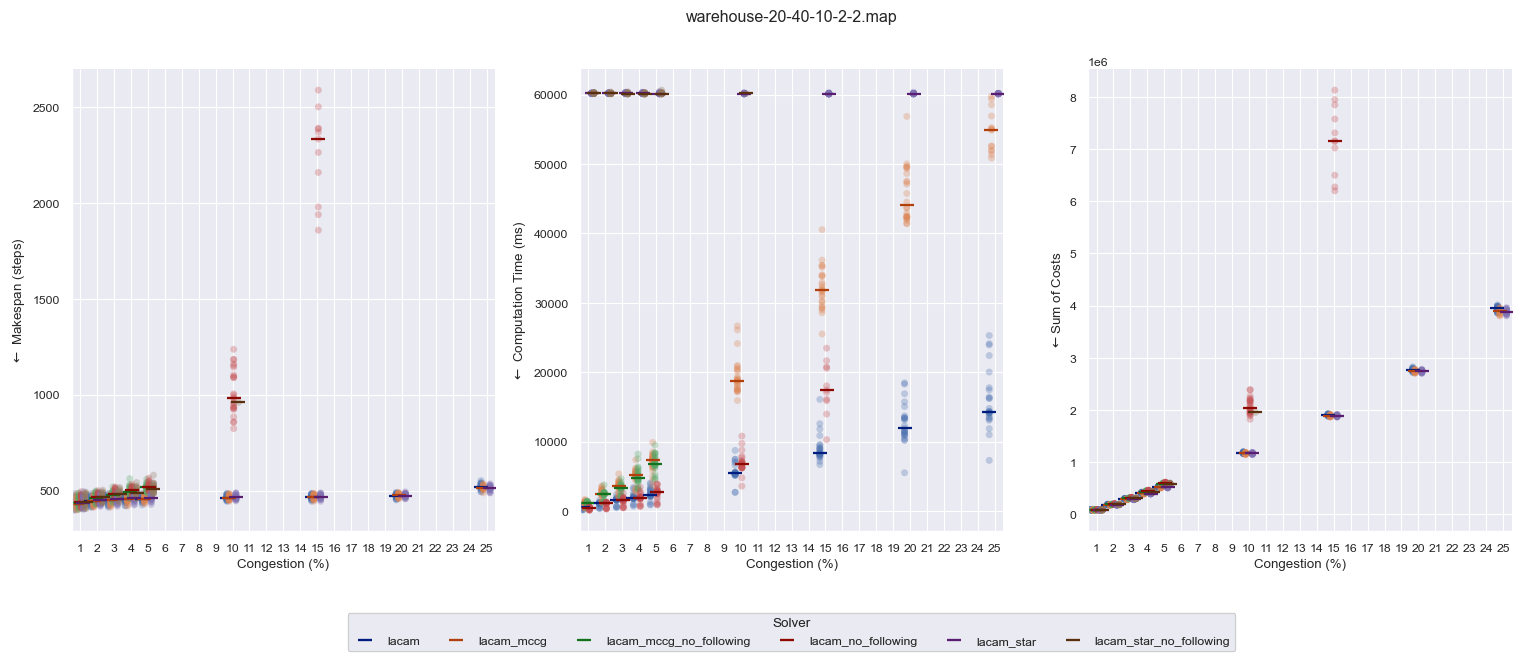

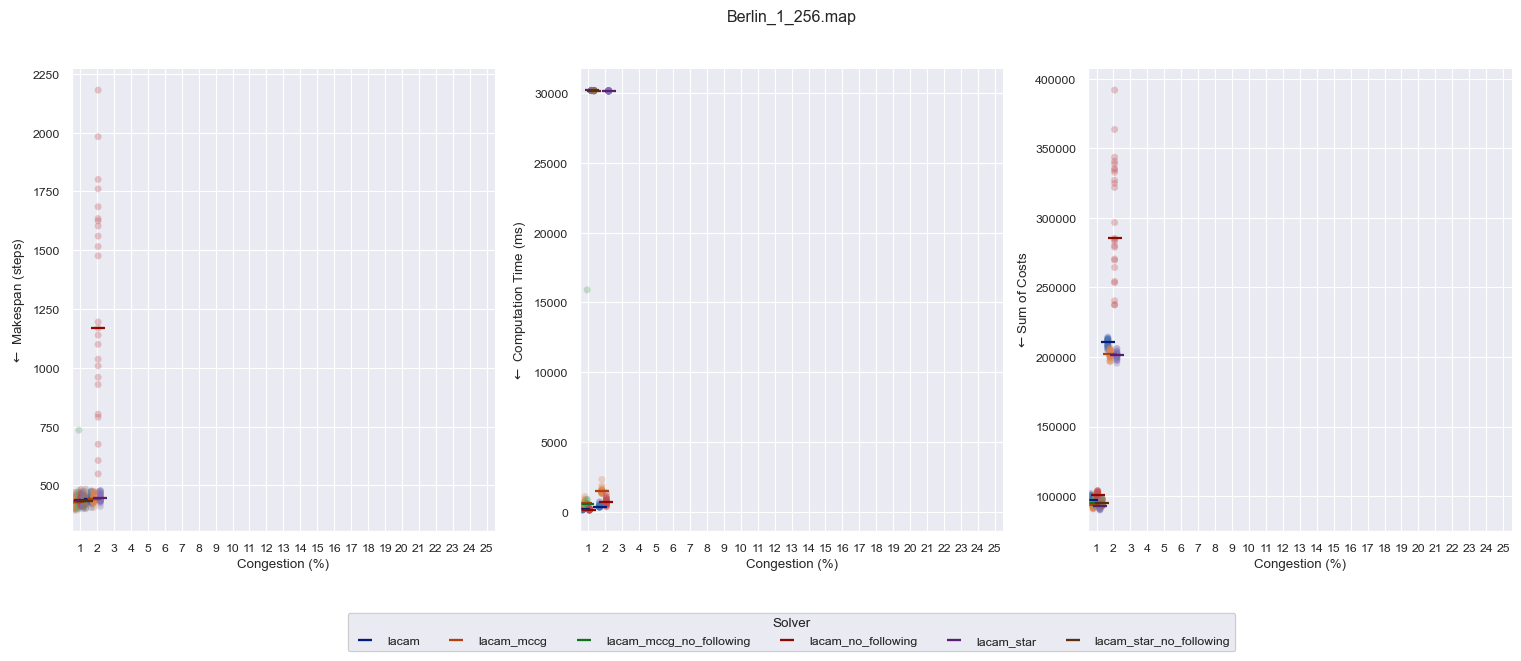

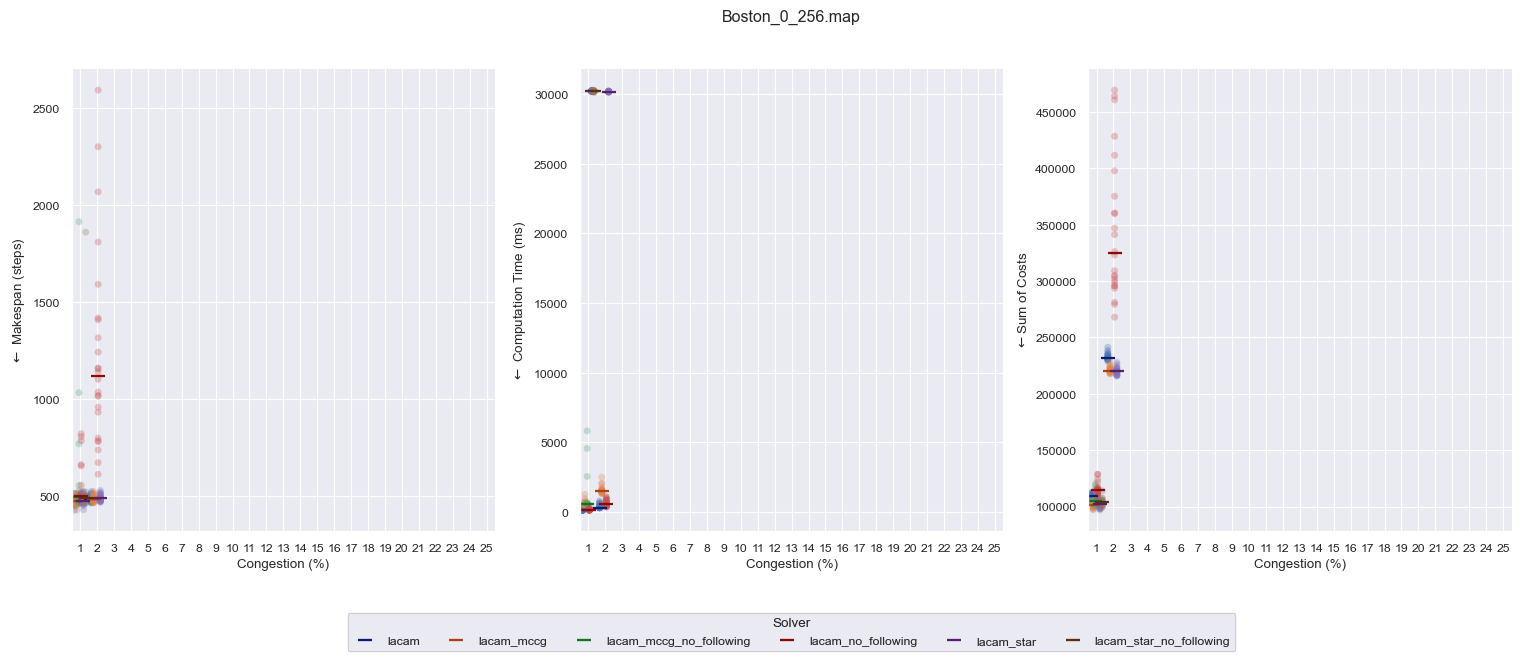

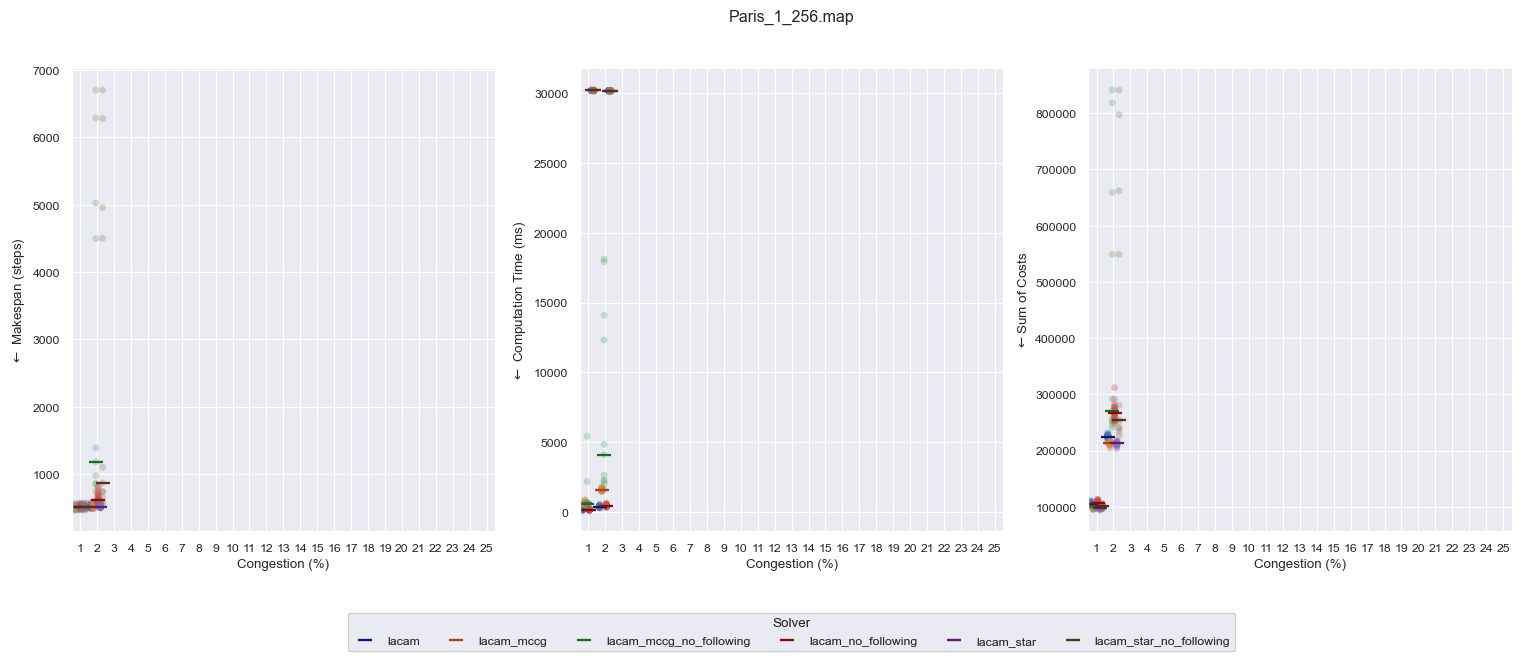

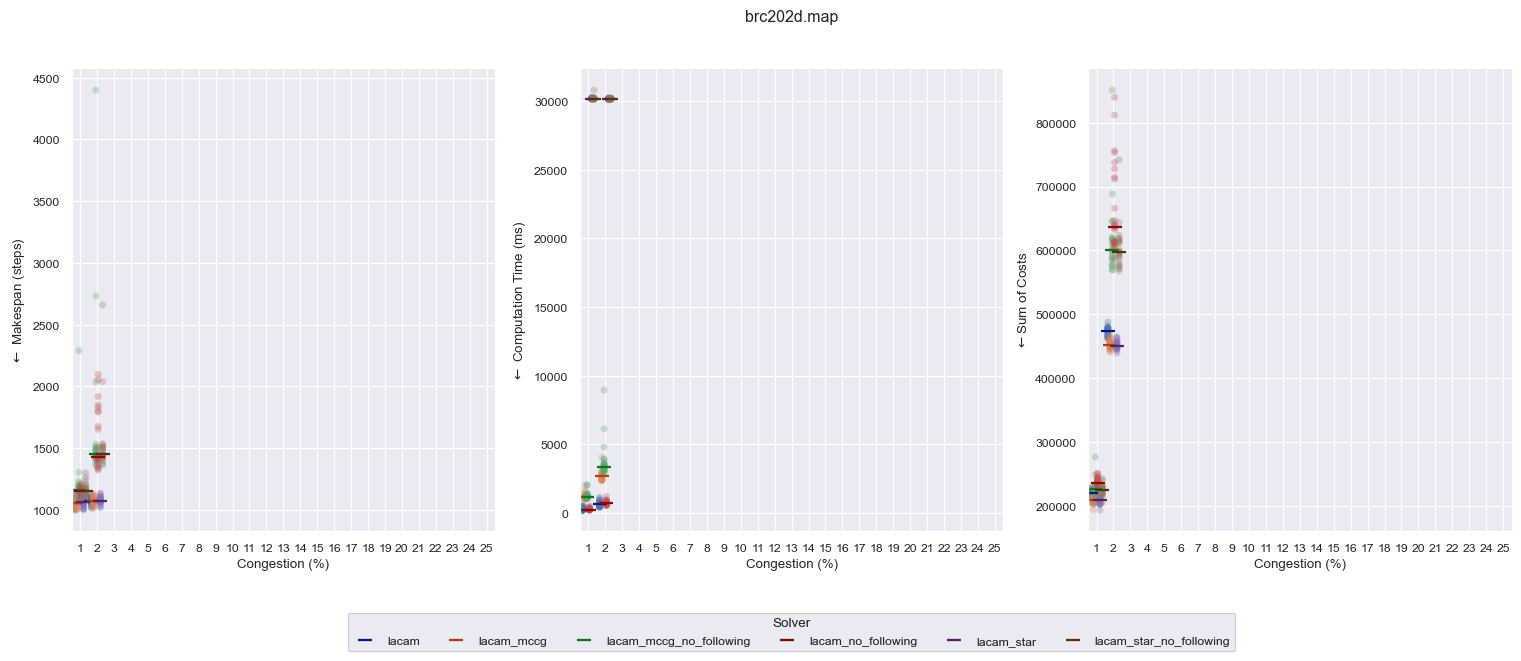

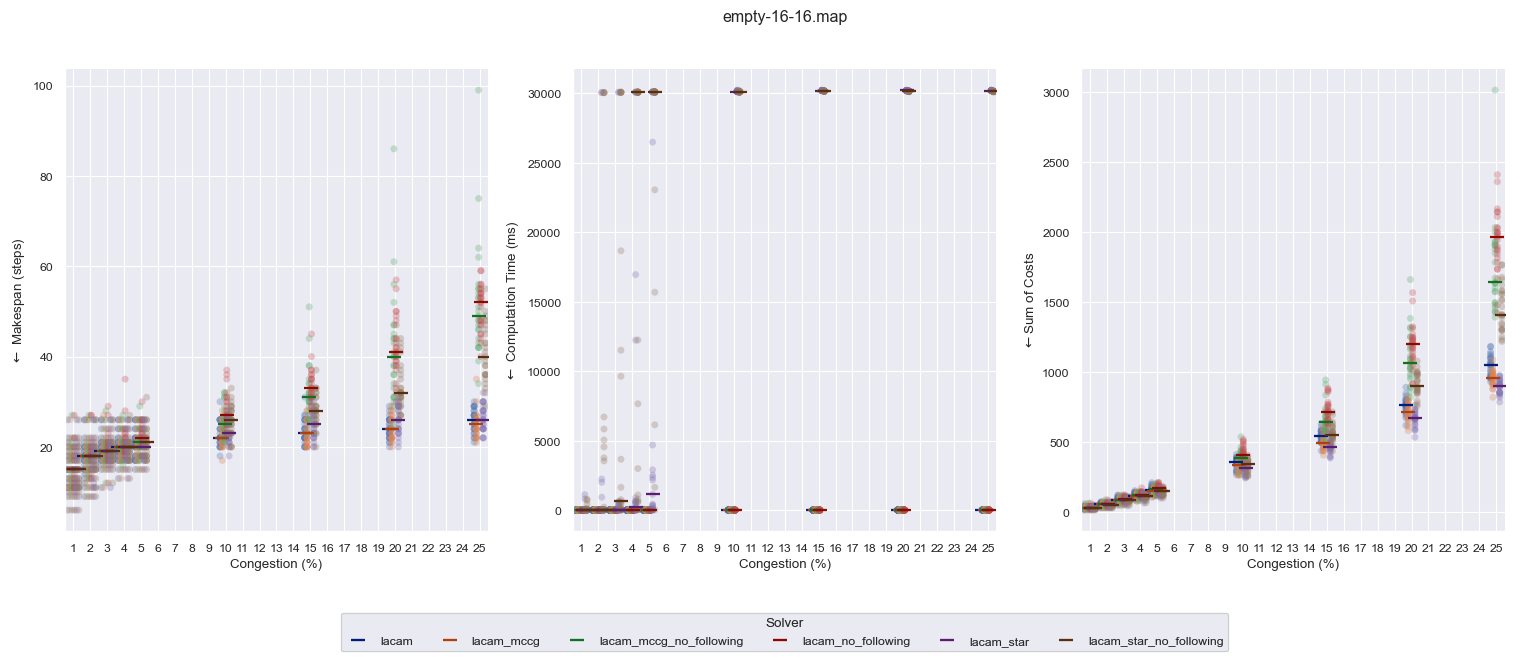

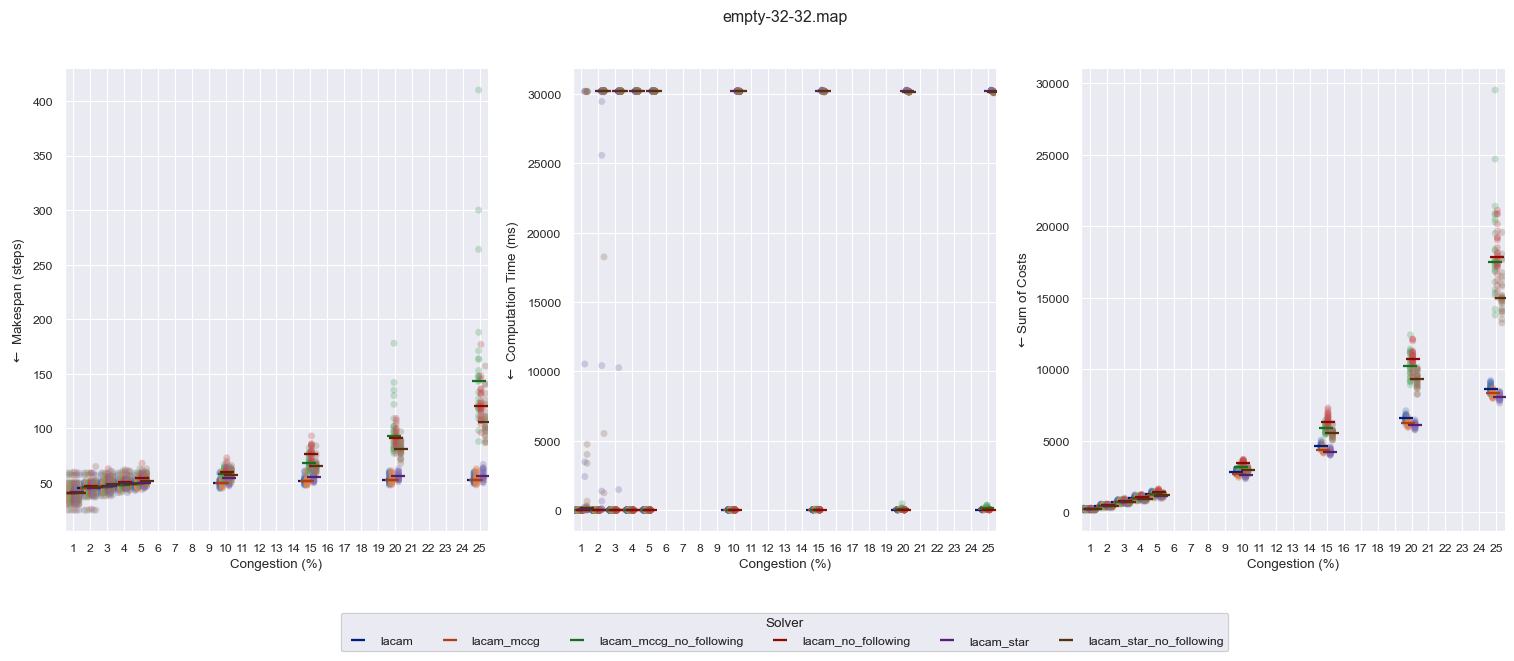

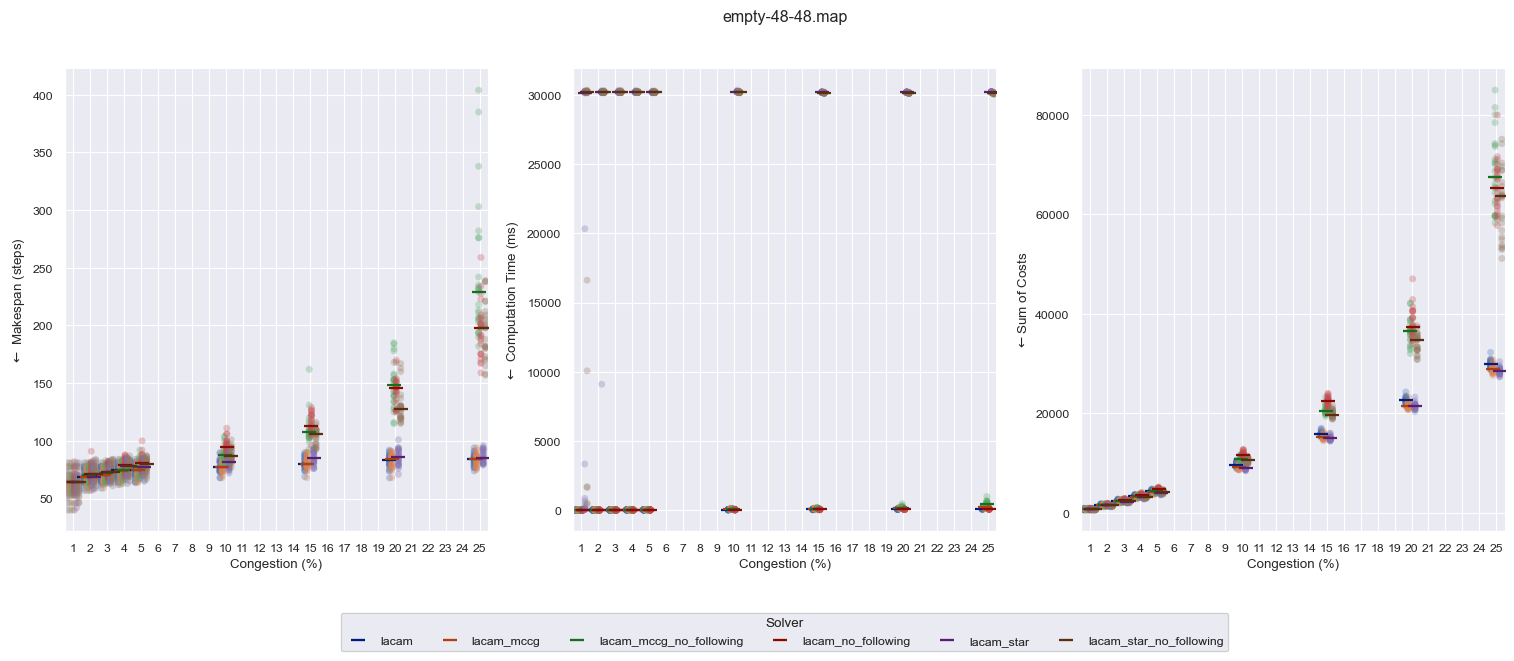

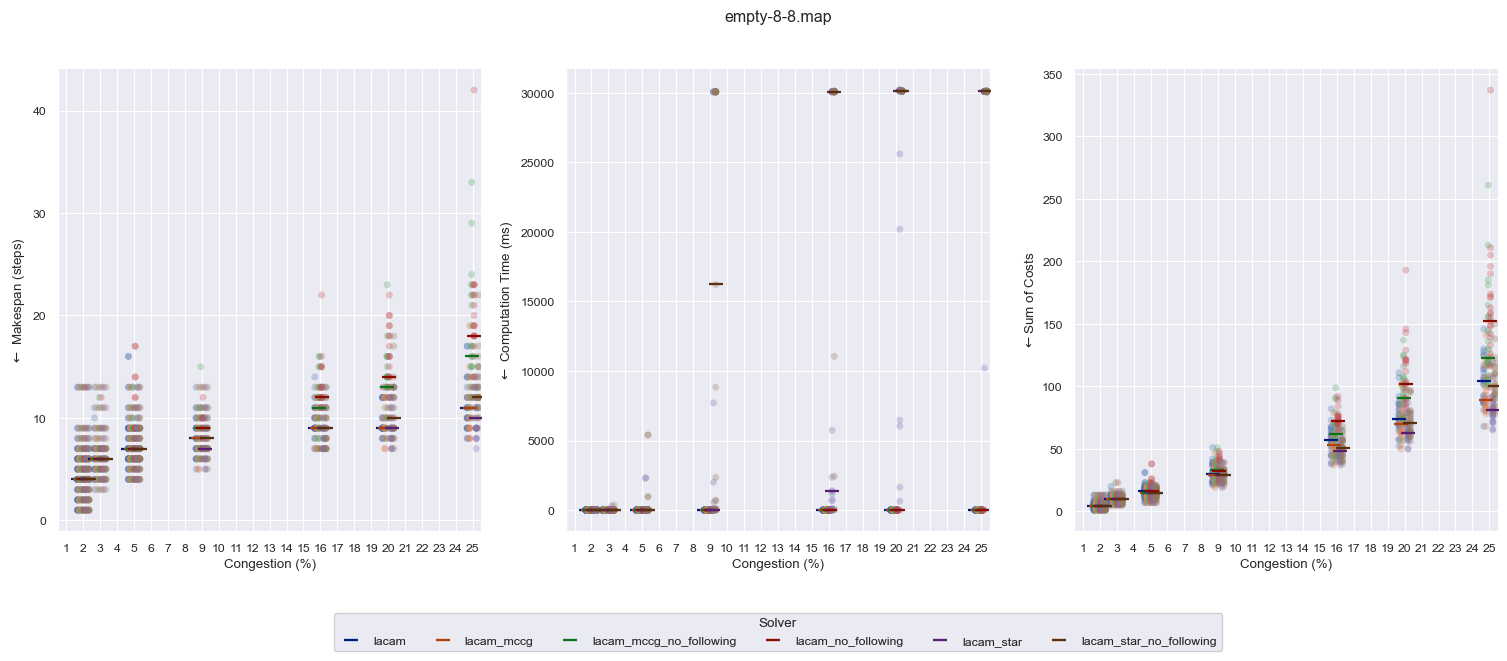

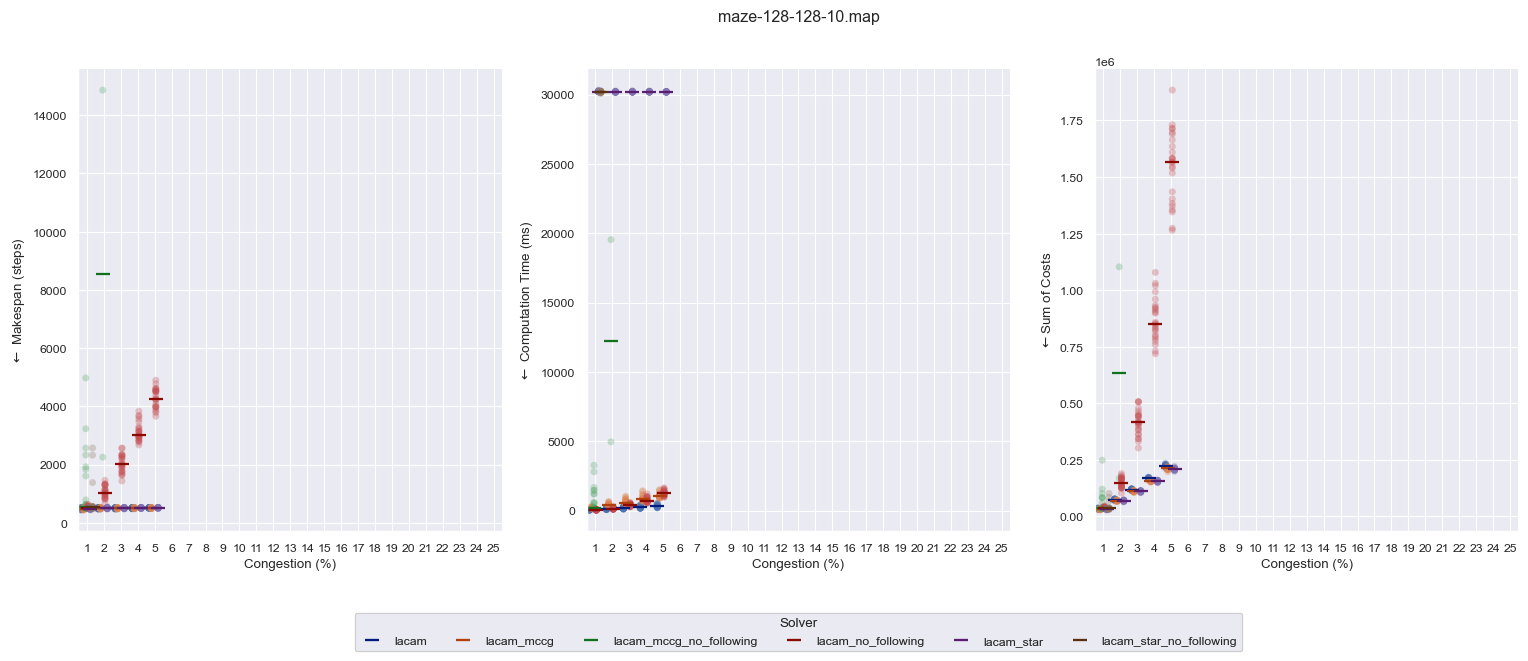

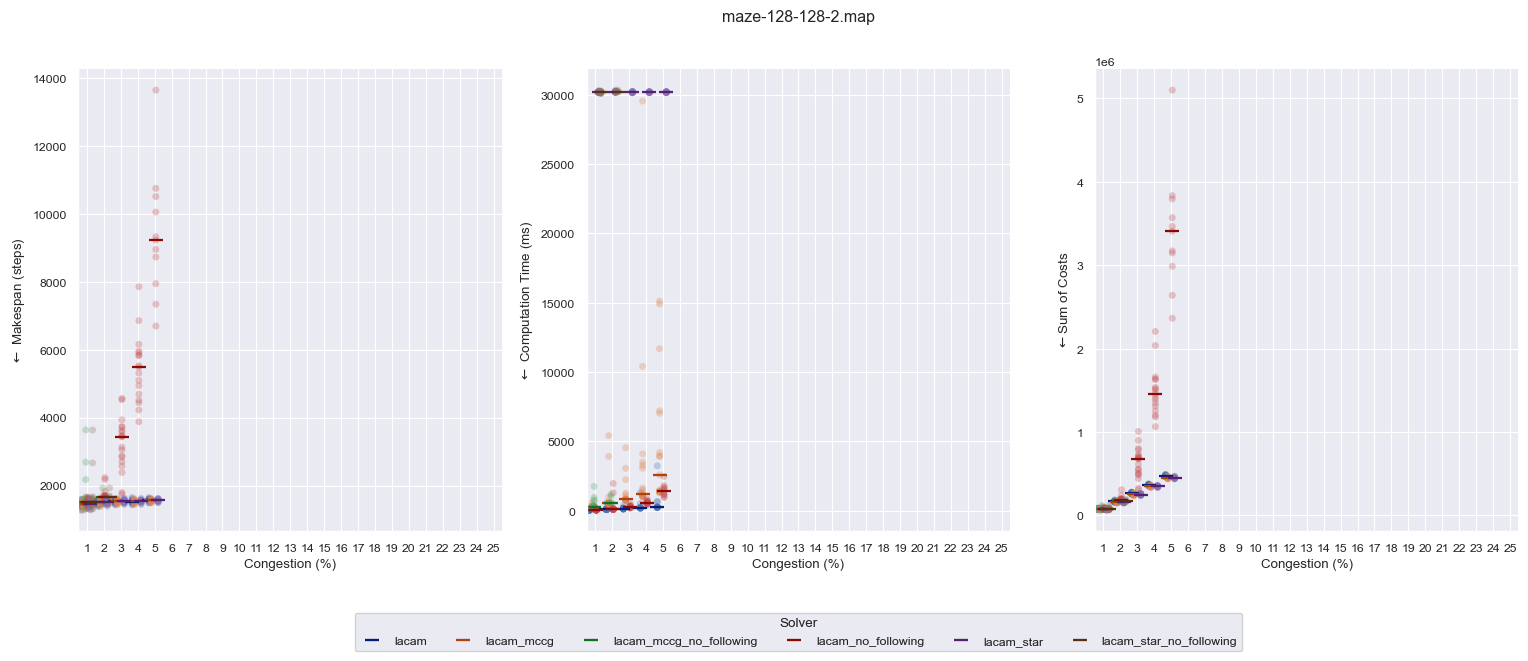

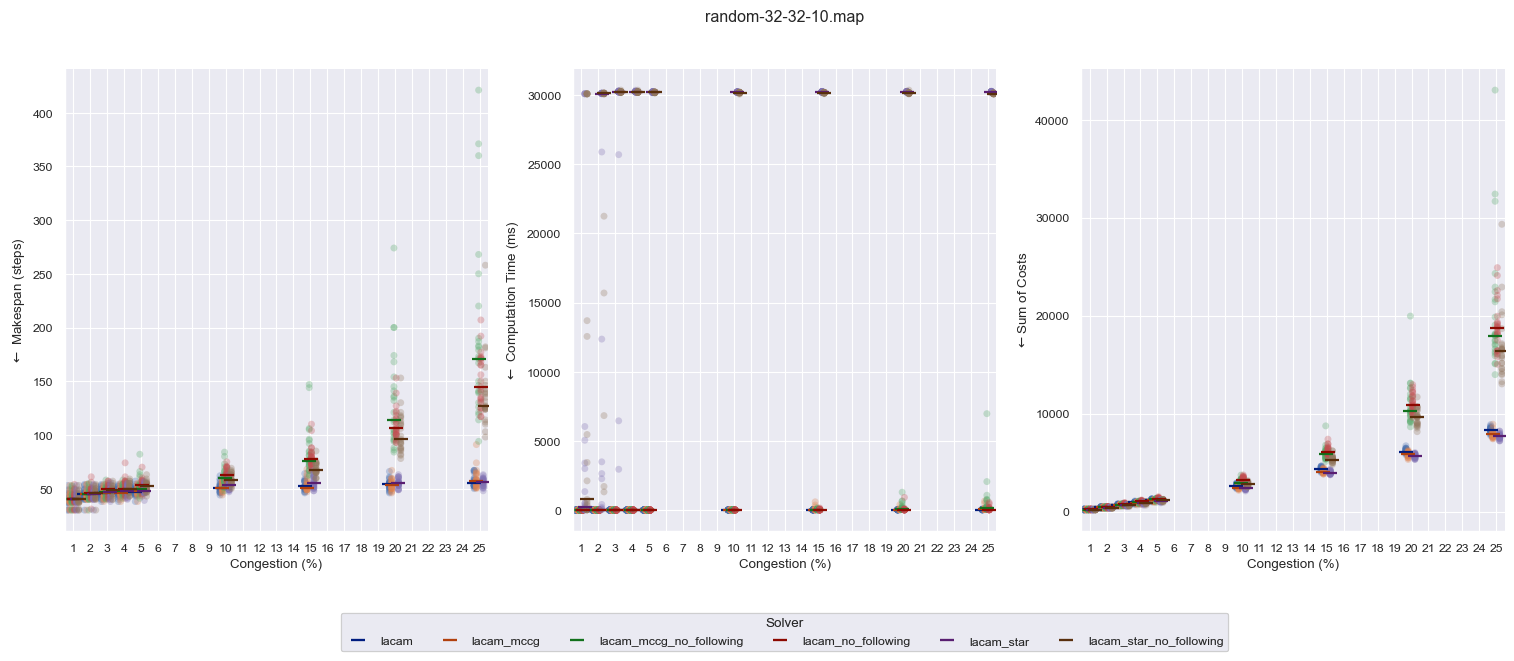

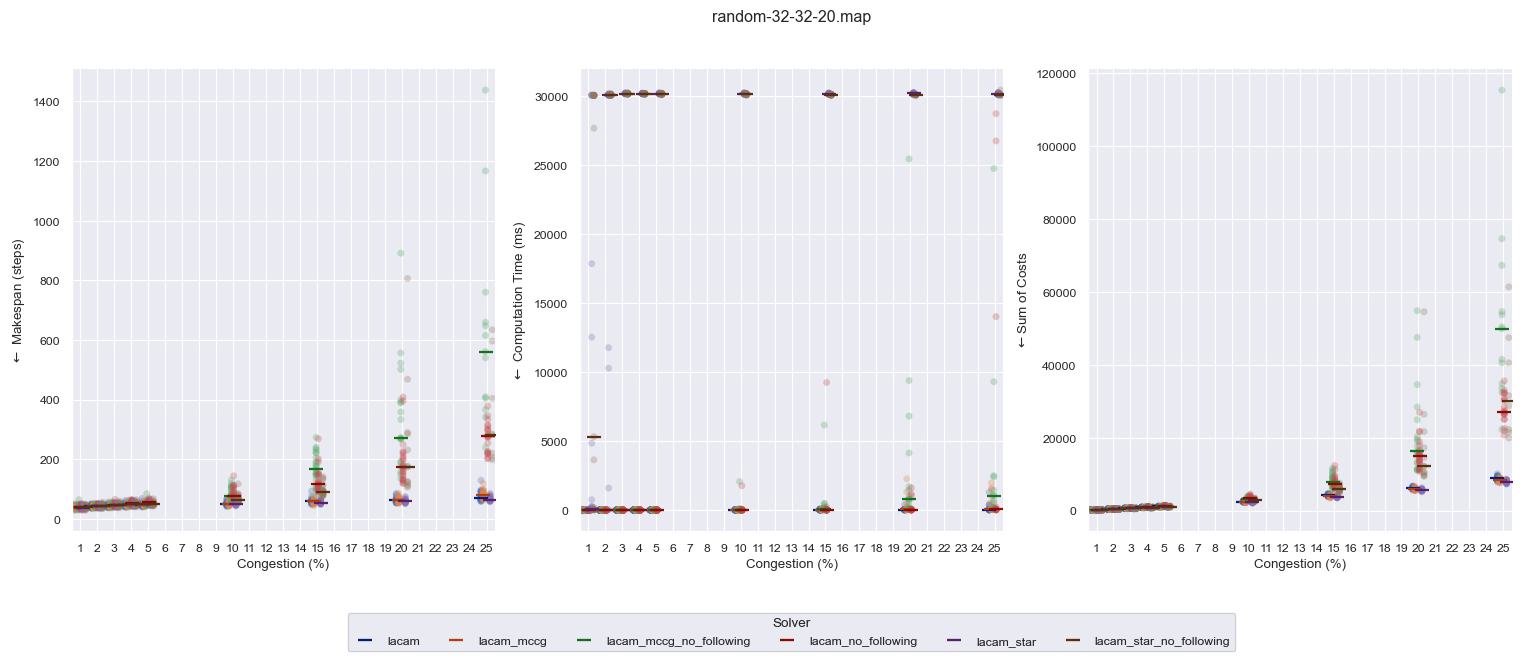

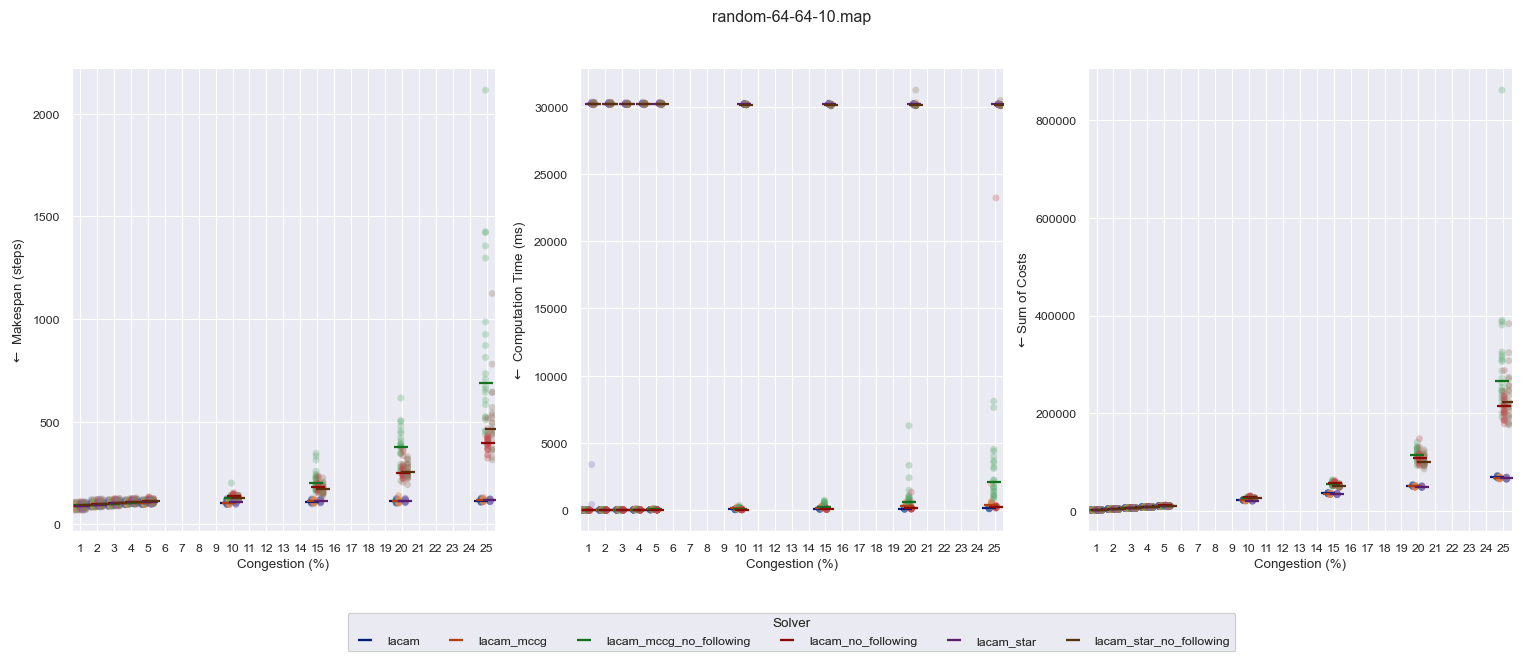

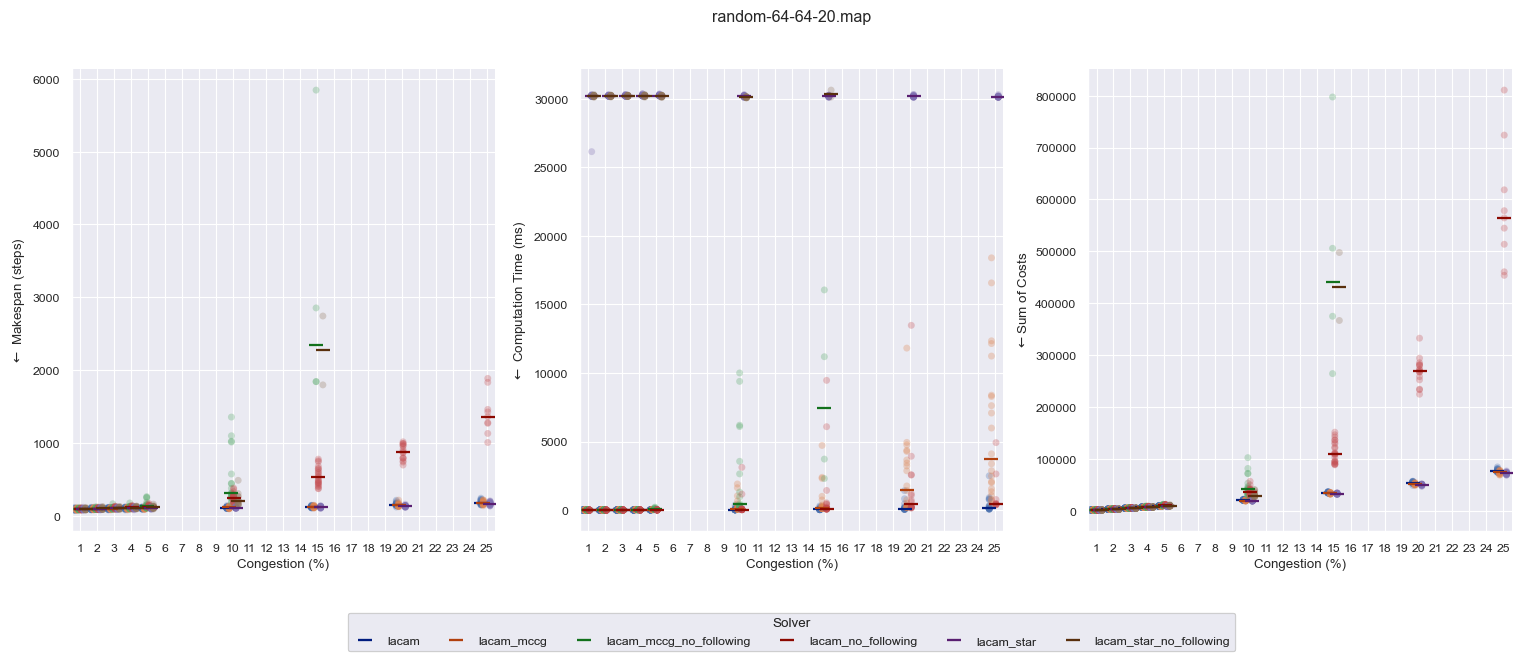

In [ ]:
for map_name in map_names:
    filtered_df = df[df["map_name"] == map_name]
    filtered_df = filtered_df[~filtered_df["solver"].str.contains("star")]
    filtered_df = filtered_df[~filtered_df["solver"].str.contains("mccg")]
    filtered_df = filtered_df.assign(
        congestion=(100 * filtered_df["num_agents"] / filtered_df["num_open_vertices"])
        .round(0)
        .astype(int)
    )
    filtered_df = filtered_df.sort_values(by="solver")

    fields = ["makespan", "comp_time", "soc"]
    ylabels = {
        "makespan": "$\\leftarrow$ Makespan (steps)",
        "comp_time": "$\\leftarrow$ Computation Time (ms)",
        "soc": "$\\leftarrow$Sum of Costs",
    }

    f, axs = plt.subplots(1, len(fields))
    f.suptitle(map_name)
    f.set_size_inches(18, 6)

    for i, field in enumerate(fields):
        ax = axs[i]

        melted = filtered_df.melt(
            id_vars=["congestion", "solver", "solved"],
            var_name="measurement",
            value_vars=[field],
        )

        melted = melted[melted["solved"] == 1]
        # Ensure all congestion levels are represented
        for percent in range(min(congestion_percents), max(congestion_percents) + 1):
            if percent not in melted["congestion"].values:
                for solver in melted["solver"].unique():
                    melted = pd.concat(
                        [
                            melted,
                            pd.DataFrame(
                                {
                                    "congestion": [percent],
                                    "solver": [solver],
                                    "solved": [1],
                                    "measurement": [field],
                                    "value": [float("nan")],
                                }
                            ),
                        ],
                        ignore_index=True,
                    )

        sns.despine(left=False, bottom=False)
        ax = sns.stripplot(
            data=melted,
            x="congestion",
            y="value",
            hue="solver",
            dodge=True,
            alpha=0.3,
            jitter=0,
            ax=ax,
            legend=False,
            zorder=1,
            # palette="pastel",
        )

        ax = sns.pointplot(
            data=melted,
            x="congestion",
            y="value",
            hue="solver",
            dodge=0.8 - 0.8 / len(melted["solver"].unique()),
            palette="dark",
            errorbar=None,
            markers="_",
            markersize=10,
            linestyle="none",
            ax=ax,
            legend=True,
            estimator="median",
        )

        # include full range of congestion even if particular map is missing it
        # ax.set_xticks(range(len(congestion_percents)))
        # ax.set_xticklabels(congestion_percents)

        # ax.set_ylim(bottom=0, top=None)

        ax.set_xlabel("Congestion (%)")
        ax.set_ylabel(ylabels[field])

        ax.get_legend().remove()
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        f.legend(
            legend_handles,
            legend_labels,
            loc="lower center",
            bbox_to_anchor=(0.5, -0.1),
            ncol=len(melted["solver"].unique()),
            frameon=True,
            title="Solver",
        )
        ax.grid(True)
    plt.subplots_adjust(left=0.1, right=0.9, wspace=0.2)
    f.savefig(fig_dir / f"{map_name}.png")
    plt.show()